In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import r2_score
np.random.seed(0)


In [2]:
os.chdir("FirstPart0.9")
os.getcwd()

'/home/users/t_wand01/Promotion/GLE Estimation/GLE Estimation Weekly/FirstPart0.9'

In [3]:

from os import listdir

directory_path = '.'
file_types = ['npy', 'npz']

np_vars = {dir_content: np.load(dir_content)
           for dir_content in listdir(directory_path)
           if dir_content.split('.')[-1] in file_types}

In [4]:
for i in np_vars.keys():
    print(i)

simulatedDataX_B10_K6_MAP.npy
coeff_B10_K3.npy
theta_MAPest_B10_K3.npy
theta_meanEst_B10_K0.npy
credibleIntervals_B10_K0.npy
MCMCsamples_B10_K0.npy
simulatedDataX_B10_K3_mean.npy
MCMCsamples_raw_B10_K0.npy
theta_meanEst_B10_K6.npy
binsX_B10.npy
credibleIntervals_B10_K6.npy
SecondPart_WeeklyCorr.npy
n_bin_B10_K3.npy
MCMCsamples_raw_B10_K6.npy
MCMCsamples_B10_K6.npy
simulatedDataX_B10_K3_MAP.npy
edgesX_B10.npy
theta_MAPest_B10_K6.npy
coeff_B10_K6.npy
FirstPart_WeeklyCorr.npy
simulatedDataX_B10_K6_mean.npy
n_bin_B10_K0.npy
simulatedDataX_B10_K0_mean.npy
MCMCsamples_B10_K3.npy
theta_direct_SLE_B10.npy
MCMCsamples_raw_B10_K3.npy
simulatedDataX_B10_K0_MAP.npy
n_bin_B10_K6.npy
coeff_B10_K0.npy
theta_MAPest_B10_K0.npy
theta_meanEst_B10_K3.npy
credibleIntervals_B10_K3.npy


In [5]:
os.chdir("..")
os.getcwd()
os.chdir("Predict")
os.getcwd()

'/home/users/t_wand01/Promotion/GLE Estimation/GLE Estimation Weekly/Predict'

## Edges of the Bins for Input Time Series Data

In [6]:
np_vars["edgesX_B10.npy"]

array([0.00523525, 0.08974787, 0.17426049, 0.25877311, 0.34328573,
       0.42779835, 0.51231097, 0.59682359, 0.68133621, 0.76584883,
       0.85036145])

## Estimated Parameters

- First ten parameters are for $D^{(1)}$
- Second ten parameters are for $D^{(2)}$
- Last remaining parameters are for Kernel $\mathcal{K}$

In [7]:
print(np.round(np_vars["theta_MAPest_B10_K3.npy"],3))



[ 0.033  0.012  0.007  0.002 -0.03  -0.065 -0.04  -0.052 -0.063 -0.065
  0.009  0.011  0.016  0.019  0.023  0.03   0.025  0.036  0.038  0.016
 -0.26  -0.158 -0.183]


In [8]:
# Into a pd.DataFrame

D1D2 = pd.DataFrame({"D1": np_vars["theta_MAPest_B10_K3.npy"][0:10],
                    "D2": np_vars["theta_MAPest_B10_K3.npy"][10:20]})

D1D2_0 = pd.DataFrame({"D1": np_vars["theta_MAPest_B10_K0.npy"][0:10],
                    "D2": np_vars["theta_MAPest_B10_K0.npy"][10:20]})

D1D2.head(), D1D2_0.head()

(         D1        D2
 0  0.033137  0.009296
 1  0.011615  0.010608
 2  0.006845  0.015760
 3  0.002054  0.018837
 4 -0.029891  0.022930,
          D1        D2
 0  0.076111  0.011321
 1  0.039494  0.014576
 2  0.014505  0.021559
 3 -0.016951  0.027687
 4 -0.064454  0.027814)

Ensure that Kernel[1] is actually the lag-1-Kernel by adding a zeroth element

In [9]:
Kernel = [0]
Kernel += list(np_vars["theta_MAPest_B10_K3.npy"][20:])
print(np.round(Kernel,3))

[ 0.    -0.26  -0.158 -0.183]


## Prediction

Taken from Eq. (7) in Clemens's Preprint

In [10]:
def getBin(x, Binning):
    # get Bin for observation x via Binning intervals Binning,
    # starts with zeroth Bin
    
    Output = int(sum(x>Binning)) - 1  
    # -1 because lowest interval boundary is minimum
    
    Output = max(0, Output) # if lower than min. in training data
    Output = min(len(Binning)-2, Output) # if higher than max. in training: N interval boundaries-> N-2 intervals
    
    return(int(Output))

    
    
getBin(0.36,np_vars["edgesX_B10.npy"])

4

In [11]:
print(np.round(np_vars["edgesX_B10.npy"],3))

[0.005 0.09  0.174 0.259 0.343 0.428 0.512 0.597 0.681 0.766 0.85 ]


In [12]:
# This gives me mean and standard deviation of the prediction

def Prediction_mean_std(X_in, d1d2_DF, Kernels, Binning, deltaT, K):
    
    
    assert type(K) == int
    
    Interval = getBin(X_in[-1], Binning)
    
    Output_m = X_in[-1]  # past value
    Output_m +=  d1d2_DF["D1"].loc[Interval] * deltaT # simple Euler ODE
    
    # now for the kernel
    
    for k in range(1,K+1): # sum over 1 to (inclusive) K
        Contribution = 0
        Contribution += Kernel[k] * ( X_in[-1] - X_in[-1-k])*deltaT
        Output_m += Contribution # Kernel effect
    
    # now the stochastic Ito-component
    Output_std = float(np.sqrt(d1d2_DF["D2"].loc[Interval] * deltaT))

        
    return( np.array([Output_m, Output_std]) )

## Test

In [13]:
X = np_vars["FirstPart_WeeklyCorr.npy"]

In [14]:
Prediction_mean_std(X[:-1], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)

array([0.19001126, 0.17489082])

In [15]:
Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)


array([0.44713989, 0.18850137])

In [16]:
m, std = Prediction_mean_std(X, D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = 3)
print(m,std)

0.4471398916296474 0.18850136774700946


# In-Sample Prediction

In [17]:
K_Length = 3

In [18]:
Means = list()
Stds = list()
TrueValues = list()
LastValues = list()
L = len(X)-K_Length-1


for i in range(L):
    TrueValues = TrueValues +  [X[-L+i+1]]
    LastValues = LastValues+  [X[-L+i]]
    mn, st = Prediction_mean_std(X[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means = Means + [mn]
    Stds = Stds + [st]


In [19]:
np.array(Stds).flatten()

array([0.09641543, 0.10299748, 0.12554014, 0.10299748, 0.09641543,
       0.10299748, 0.09641543, 0.09641543, 0.10299748, 0.15142551,
       0.09641543, 0.09641543, 0.10299748, 0.09641543, 0.10299748,
       0.09641543, 0.10299748, 0.09641543, 0.10299748, 0.12554014,
       0.10299748, 0.10299748, 0.09641543, 0.09641543, 0.10299748,
       0.10299748, 0.09641543, 0.09641543, 0.10299748, 0.09641543,
       0.09641543, 0.13724672, 0.10299748, 0.10299748, 0.10299748,
       0.12554014, 0.09641543, 0.09641543, 0.10299748, 0.09641543,
       0.10299748, 0.09641543, 0.09641543, 0.10299748, 0.10299748,
       0.09641543, 0.09641543, 0.10299748, 0.09641543, 0.09641543,
       0.10299748, 0.10299748, 0.13724672, 0.09641543, 0.10299748,
       0.10299748, 0.09641543, 0.10299748, 0.09641543, 0.12554014,
       0.09641543, 0.09641543, 0.10299748, 0.09641543, 0.09641543,
       0.12554014, 0.10299748, 0.09641543, 0.09641543, 0.09641543,
       0.10299748, 0.09641543, 0.10299748, 0.09641543, 0.09641

##### For no Memory

In [20]:
Means_0 = list()
Stds_0 = list()
TrueValues_0 = list()
LastValues_0 = list()
K_Length_0 = 0
L_0 = len(X)-K_Length_0-1


for i in range(L_0):
    TrueValues_0 = TrueValues_0 +  [X[-L_0+i+1]]
    mn, st = Prediction_mean_std(X[:-L_0+i], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length_0)
   
    Means_0 = Means_0 + [mn]
    Stds_0 = Stds_0 + [st]


### Some Confidence Interval Checks

In [21]:
LowerCI = np.array(Means)-np.array(Stds) 
UpperCI = np.array(Means)+np.array(Stds) 
ArrayTrueValues = np.array(TrueValues)

LCI_Check = 1.0*(LowerCI<ArrayTrueValues)
UCI_Check =1.0*(UpperCI>ArrayTrueValues)

InCI = LCI_Check * UCI_Check
print(np.mean(InCI))

0.6951476793248945


In [22]:
len(TrueValues)

948

In [23]:
len(X)

952

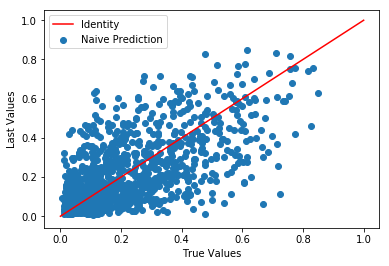

In [24]:
plt.scatter(TrueValues, LastValues, label="Naive Prediction")
plt.xlabel("True Values")
plt.ylabel("Last Values")
plt.plot([0,1],[0,1], label="Identity", c ="r")
plt.legend()
plt.show()

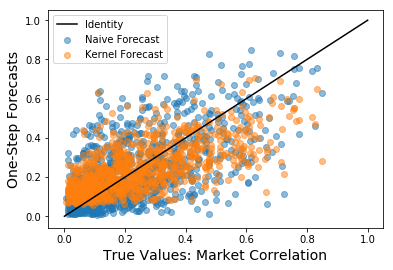

In [48]:
plt.scatter(TrueValues, LastValues, label="Naive Forecast", alpha = 0.5)
#plt.scatter(TrueValues_0, Means_0, label="Langevin without Kernel", alpha = 0.5)
plt.scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

#### Root Mean Square Error and R² Metrics

In [26]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(Means))**2.))

0.1320584871287953

In [27]:
np.sqrt(np.mean((np.array(TrueValues)-np.array(LastValues))**2.))

0.16001485352115827

In [28]:
r2_score(y_true=TrueValues, y_pred=Means)

0.44874110007884294

In [29]:
r2_score(y_true=TrueValues_0, y_pred=Means_0) #0.3487483090652824

0.349004149166632

In [30]:
r2_score(y_true=TrueValues, y_pred=LastValues)

0.19063657392809652

# Out-Of-Sample Prediction

In [31]:
test_data = np_vars["SecondPart_WeeklyCorr.npy"]
len(test_data)

105

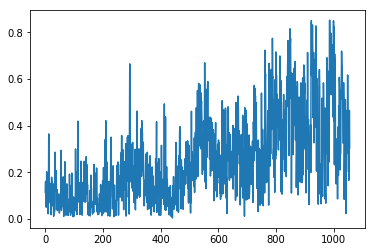

In [32]:
X_full = np.concatenate([X,test_data])
plt.plot(X_full)
plt.show()

In [33]:
Means_test = list()
Stds_test = list()
TrueValues_test = list()
LastValues_test = list()
L = len(test_data)+1  # +1 because first TrueValues is [X[-L+i+1]]


for i in range(L):
    TrueValues_test = TrueValues_test +  [X_full[-L+i+1]]
    LastValues_test = LastValues_test+  [X_full[-L+i]]
    mn, st = Prediction_mean_std(X_full[:-L+i], D1D2, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length)
   
    Means_test = Means_test + [mn]
    Stds_test = Stds_test + [st]


In [34]:
len(X_full)

1057

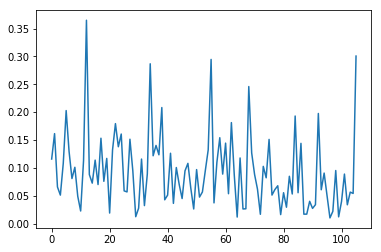

In [35]:
plt.plot(X_full[:-L_0])

##### For no Memory

In [36]:
Means_0_test = list()
Stds_0_test = list()
TrueValues_0_test = list()
LastValues_0_test = list()
K_Length_0 = 0
L_0 = len(test_data)+1  # +1 because first TrueValues is [X[-L+i+1]]

print(L_0-1)
for i in range(L_0):

    mn, st = Prediction_mean_std(X_full[:-L_0+i], D1D2_0, Kernel, Binning=np_vars["edgesX_B10.npy"],
                           deltaT = 1, K = K_Length_0)
   
    TrueValues_0_test = TrueValues_0_test +  [X_full[-L+i+1]]
    Means_0_test = Means_0_test + [mn]
    Stds_0_test = Stds_0_test + [st]


105


In [37]:
len(TrueValues_0_test), len(Means_0_test), len(TrueValues_test)

(106, 106, 106)

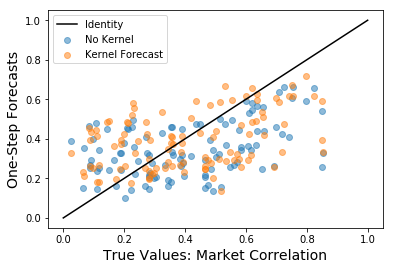

In [38]:
#plt.scatter(TrueValues_test, LastValues_test, label="Naive Forecast", alpha = 0.5)
plt.scatter(TrueValues_0_test, Means_0_test, label="No Kernel", alpha = 0.5)

plt.scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)

fs = 14
plt.xlabel("True Values: Market Correlation",fontsize = fs)
plt.ylabel("One-Step Forecasts",fontsize = fs)
plt.plot([0,1],[0,1], label="Identity", c ="k")
plt.legend()
plt.show()

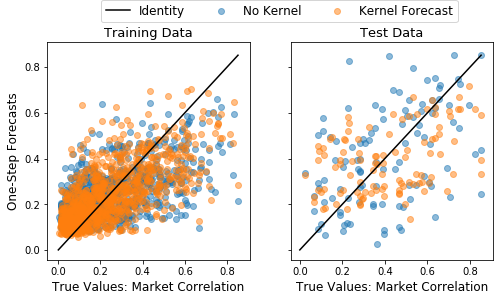

In [52]:
fig, ax = plt.subplots(1, 2, figsize = (8,4),sharey=True)


Maximum = max(max(TrueValues), max(TrueValues_0), max(Means_0), max(Means),
              max(TrueValues_test), max(TrueValues_0_test), max(Means_0_test),max(Means_test))


ax[0].scatter(TrueValues_0, Means_0, label="No Kernel", alpha = 0.5)
ax[0].scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 12
ax[0].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[0].set_ylabel("One-Step Forecasts",fontsize = fs)
ax[0].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[0].set_title("Training Data", fontsize = fs+1)
#ax[0].legend()


ax[1].scatter(TrueValues_0_test, LastValues_test, label="No Kernel", alpha = 0.5)
ax[1].scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)
ax[1].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[1].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[1].set_title("Test Data", fontsize = fs+1)


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2,0.925),ncol=3, fontsize = fs)

plt.savefig("Prediction_Evaluation.pdf", bbox_inches="tight", dpi = 500)

plt.show()

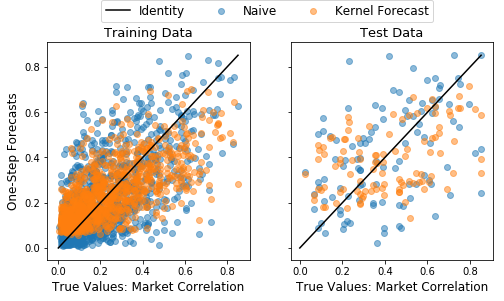

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (8,4),sharey=True)


Maximum = max(max(TrueValues), max(TrueValues_0), max(Means_0), max(Means),
              max(TrueValues_test), max(TrueValues_0_test), max(LastValues_test))


ax[0].scatter(TrueValues, LastValues, label="Naive", alpha = 0.5)
ax[0].scatter(TrueValues, Means, label="Kernel Forecast", alpha = 0.5)

fs = 12
ax[0].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[0].set_ylabel("One-Step Forecasts",fontsize = fs)
ax[0].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[0].set_title("Training Data", fontsize = fs+1)
#ax[0].legend()


ax[1].scatter(TrueValues_test, LastValues_test, label="Naive", alpha = 0.5)
ax[1].scatter(TrueValues_test, Means_test, label="Kernel Forecast", alpha = 0.5)
ax[1].set_xlabel("True Values: Market Correlation",fontsize = fs)
ax[1].plot([0,Maximum],[0,Maximum], label="Identity", c ="k")
ax[1].set_title("Test Data", fontsize = fs+1)


handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.2,0.925),ncol=3, fontsize = fs)

plt.savefig("Prediction_Evaluation_Naive.pdf", bbox_inches="tight", dpi = 500)

plt.show()

#### Root Mean Square Error and R² 

In [40]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(Means_test))**2.))

0.20308709506861378

In [41]:
np.sqrt(np.mean((np.array(TrueValues_0_test)-np.array(Means_0_test))**2.))

0.2058229593832951

In [42]:
np.sqrt(np.mean((np.array(TrueValues_test)-np.array(LastValues_test))**2.))

0.22587837243543119

In [43]:
r2_score(y_true=TrueValues_test, y_pred=Means_test)

0.10451972177595992

In [44]:
r2_score(y_true=TrueValues_0_test, y_pred=Means_0_test) # 0.07228434075280932

0.08023049361428591

In [45]:
r2_score(y_true=TrueValues_test, y_pred=LastValues_test)

-0.10774722298799988

In [46]:
Means_test[-1], TrueValues_test[-1]

(0.2687380799137333, 0.11584862290253742)

### Again, CIs

In [47]:
LowerCI_test = np.array(Means_test)-np.array(Stds_test) 
UpperCI_test = np.array(Means_test)+np.array(Stds_test) 
ArrayTrueValues_test = np.array(TrueValues_test)

LCI_Check_test = 1.0*(LowerCI_test<ArrayTrueValues_test)
UCI_Check_test =1.0*(UpperCI_test>ArrayTrueValues_test)

InCI_test = LCI_Check_test * UCI_Check_test
print(np.mean(InCI_test))

0.5471698113207547
